In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
import shutil

In [50]:
# Image and batch size
image_size = 224
batch_size = 16

# Path to the main directory containing the 12 folders
main_dir = r"C:\Users\himan\Desktop\training_set\training_set"

# Target number of images per folder
target_images = 500

# Ensure each folder has only 500 images
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)
    
    # Ensure it's a directory (skip any files in the main directory)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        
        # Check if the folder has more than the target number of images
        if len(images) > target_images:
            # Randomly select images to keep
            images_to_keep = random.sample(images, target_images)
            
            # Remove images not in the selection
            for image in images:
                if image not in images_to_keep:
                    os.remove(os.path.join(folder_path, image))

print("Reduction to 500 images per folder completed.")

# Now, load the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  main_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  main_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)


Reduction to 500 images per folder completed.
Found 5000 files belonging to 10 classes.
Using 3500 files for training.
Found 5000 files belonging to 10 classes.
Using 1500 files for validation.


In [51]:
class_names = train_ds.class_names

In [52]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

Configuring dataset for better performance

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Data Augmentation layer

In [60]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Functions to return some information about the data

In [63]:
def main(train_data_path): 
    """
    return training and testing dataframes including 2 columns image path and its label
    Args:
      train_data_path (string): string includes your train data path
      test_data_path (string): string includes your test data path
      note: data_path argument must contains your classes dirs
    Returns:
      train_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the training images and the label of each image
      test_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the testing images and the label of each image

    """    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))
        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)        
        train_df = obtain_train_df(filepaths, labels)      
    return train_df
def get_fileList(classes_list, dirs, filepaths, labels):   
    
    """
    return file paths list including all full image paths and label for each one    
    Args:
      classes_list (list): list includes name of classes dirs
      dirs (string): the data path
      filepaths (list): empty list to fill with images paths later
      labels (list): empty list to fill with each image label later      
    Returns:
      count (scalar):  number of images in your dataset
    """  
    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)        
    return filepaths, labels
def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    """
    return nothing, it fills the filepaths list with all the images paths and its labels    
    Args:
      flist (list) : contains all the image names in certain class
      classes_list (list): list includes name of classes dirs
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      label (string): label for a specific image      
    Returns:
      nothing
    """   
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)
def obtain_train_df(filepaths, labels):
    """
    Return Dataframe with 2 columns contains each image path with its label
    Args:
      filepaths (list): stores all the images paths
      labels (list): stores the label of each image in the dataset
      
    Returns:
      train_df (DataFrame):  Dataframe with 2 columns contains each image path with its label
    """
    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

EDA

In [66]:
data_df = main(main_dir)

In [67]:
data_df.head()

,image_path,label
0,C:\Users\himan\Desktop\training_set\training_s...,Cattle Egret
1,C:\Users\himan\Desktop\training_set\training_s...,Cattle Egret
2,C:\Users\himan\Desktop\training_set\training_s...,Cattle Egret
3,C:\Users\himan\Desktop\training_set\training_s...,Cattle Egret
4,C:\Users\himan\Desktop\training_set\training_s...,Cattle Egret


In [69]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 10 classes
We have 5000 images


In [71]:
data_df['label'].value_counts()

label
Cattle Egret                 500
Common Kingfisher            500
Gray Wagtail                 500
Northern Lapwing             500
Red-Wattled Lapwing          500
Ruddy Shelduck               500
Sarus Crane                  500
White Wagtail                500
White-Breasted Kingfisher    500
White-Breasted Waterhen      500
Name: count, dtype: int64

Data is perfectly balanced!!

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
test_split_size = 0.3
train_df, test_df=train_test_split(data_df, test_size=test_split_size, shuffle=True, random_state=123, stratify=data_df['label'])  

In [76]:
train_df.head()

,image_path,label
2853,C:\Users\himan\Desktop\training_set\training_s...,Ruddy Shelduck
4202,C:\Users\himan\Desktop\training_set\training_s...,White-Breasted Kingfisher
1118,C:\Users\himan\Desktop\training_set\training_s...,Gray Wagtail
2325,C:\Users\himan\Desktop\training_set\training_s...,Red-Wattled Lapwing
3689,C:\Users\himan\Desktop\training_set\training_s...,White Wagtail


In [77]:
train_df.shape

(3500, 2)

In [78]:
test_df.head()

,image_path,label
1818,C:\Users\himan\Desktop\training_set\training_s...,Northern Lapwing
3121,C:\Users\himan\Desktop\training_set\training_s...,Sarus Crane
2417,C:\Users\himan\Desktop\training_set\training_s...,Red-Wattled Lapwing
4590,C:\Users\himan\Desktop\training_set\training_s...,White-Breasted Waterhen
3344,C:\Users\himan\Desktop\training_set\training_s...,Sarus Crane


In [79]:
test_df.shape

(1500, 2)

In [82]:
print(f"We have {len(train_df)} training images and {len(test_df)} testing images")

We have 3500 training images and 1500 testing images


In [87]:
train_df['label'].value_counts()

label
Ruddy Shelduck               350
White-Breasted Kingfisher    350
Gray Wagtail                 350
Red-Wattled Lapwing          350
White Wagtail                350
Northern Lapwing             350
Sarus Crane                  350
Common Kingfisher            350
Cattle Egret                 350
White-Breasted Waterhen      350
Name: count, dtype: int64

In [89]:
test_df['label'].value_counts()

label
Northern Lapwing             150
Sarus Crane                  150
Red-Wattled Lapwing          150
White-Breasted Waterhen      150
White Wagtail                150
Cattle Egret                 150
Ruddy Shelduck               150
Common Kingfisher            150
White-Breasted Kingfisher    150
Gray Wagtail                 150
Name: count, dtype: int64

Importing the base model (VGG16)

In [92]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

Creating the model architecture

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

 Compiling the model

In [104]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

Early Stopping to stop training when validation accuracy has stopped improving
Saving weights on all iterations
Saving weights if they produce the best validaiton accuracy
Saving the trained model
Initial number of epochs = 60

In [109]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.001, restore_best_weights=True)

# Correcting the file extension for the checkpoint
cp = tf.keras.callbacks.ModelCheckpoint(filepath="training_weights/checkpoints/cp-{epoch}.weights.h5",
                                         save_weights_only=True,
                                         verbose=1)

# Fixing the typo in 'monitor'
best = tf.keras.callbacks.ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.weights.h5",
                                           save_weights_only=True,
                                           monitor="val_accuracy",
                                           mode="max",
                                           save_best_only=True)

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=val_ds,
                    callbacks=[es, cp, best])

model.save('training_weights/models/vgg16_modified.h5')

Epoch 1/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1370 - loss: 2.2605
Epoch 1: saving model to training_weights/checkpoints/cp-1.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.1371 - loss: 2.2601 - val_accuracy: 0.3222 - val_loss: 1.8509
Epoch 2/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2756 - loss: 1.9117
Epoch 2: saving model to training_weights/checkpoints/cp-2.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.2758 - loss: 1.9112 - val_accuracy: 0.4545 - val_loss: 1.3648
Epoch 3/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4081 - loss: 1.5805
Epoch 3: saving model to training_weights/checkpoints/cp-3.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 570s 3s/step - accuracy: 0.4082 - loss: 1.5803 - val_accuracy: 0.5735 - val_loss: 1.1383
Epoch 4/60
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4761 - loss: 1.3906
Epoch 4: saving model to training_weights/checkpoints/cp-4.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━

Fine-tuning the trained model

In [112]:
base_model.trainable = True
for layer in base_model.layers[:12]:
    layer.trainable = False

Compiling the model again

In [115]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training again for fine-tuning

In [120]:
# EarlyStopping callback
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=4, min_delta=0.001, restore_best_weights=True
)

# ModelCheckpoint for saving checkpoints during training
cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="ft_weights/checkpoints/cp-{epoch}.weights.h5",  # Updated extension
    save_weights_only=True,
    verbose=1
)

# ModelCheckpoint for saving the best model based on validation accuracy
best = tf.keras.callbacks.ModelCheckpoint(
    filepath="ft_weights/best/model_best_val_loss.weights.h5",  # Updated extension
    save_weights_only=True,
    monitor="val_accuracy",  # Corrected typo in "monitor"
    mode="max",
    save_best_only=True
)

# Fitting the model
fhistory = model.fit(
    train_ds,
    epochs=history.epoch[-1] + 40,
    validation_data=val_ds,
    initial_epoch=history.epoch[-1],
    callbacks=[es, cp, best]
)

Epoch 19/58
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7957 - loss: 0.6573
Epoch 19: saving model to ft_weights/checkpoints/cp-19.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 674s 3s/step - accuracy: 0.7958 - loss: 0.6570 - val_accuracy: 0.8850 - val_loss: 0.4559
Epoch 20/58
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8675 - loss: 0.4171
Epoch 20: saving model to ft_weights/checkpoints/cp-20.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 779s 4s/step - accuracy: 0.8675 - loss: 0.4172 - val_accuracy: 0.8783 - val_loss: 0.4499
Epoch 21/58
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8763 - loss: 0.3917
Epoch 21: saving model to ft_weights/checkpoints/cp-21.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 776s 4s/step - accuracy: 0.8764 - loss: 0.3917 - val_accuracy: 0.8824 - val_loss: 0.4582
Epoch 22/58
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9071 - loss: 0.3198
Epoch 22: saving model to ft_weights/checkpoints/cp-22.weights.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 908s 4s/s

Classification Report

In [125]:
# Generate predictions on the test dataset
y_pred = []
y_true = []

# Loop through the test dataset batches and collect predictions and true labels
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_pred.extend(predicted_labels.numpy())
    y_true.extend(labels.numpy())

# Print the classification report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

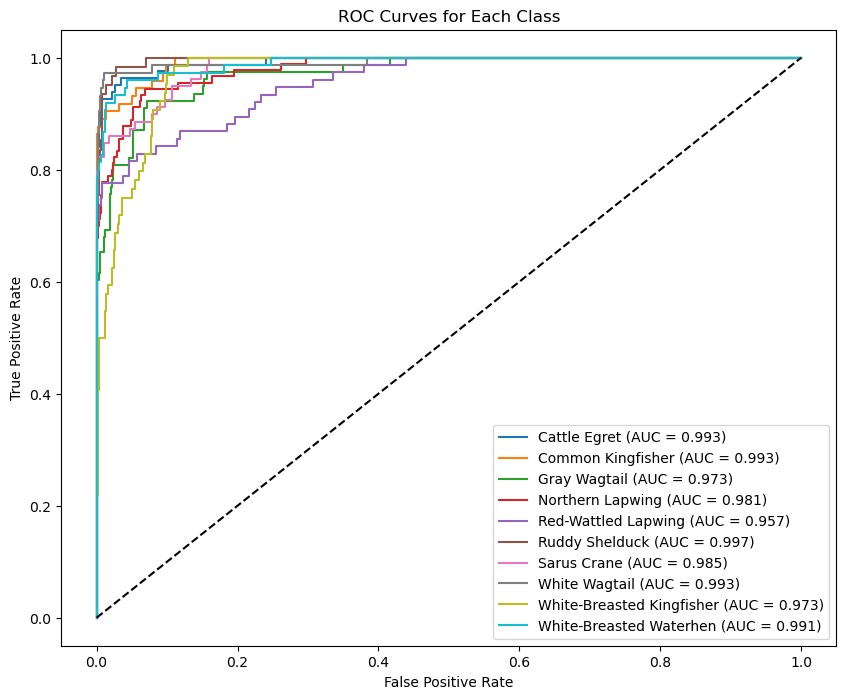

In [127]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Get the true labels and predictions for ROC AUC
y_true = []
y_pred_proba = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred_proba.extend(predictions)

# Binarize the true labels for multi-class ROC AUC
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

# Calculate the AUC for each class and the macro-average
auc_values = {}
for i in range(len(class_names)):
    auc_values[class_names[i]] = roc_auc_score(y_true_bin[:, i], np.array(y_pred_proba)[:, i])

# Print AUC values for each class
print("AUC for each class:")
for class_name, auc_value in auc_values.items():
    print(f"{class_name}: {auc_value:.3f}")

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(y_pred_proba)[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_values[class_names[i]]:.3f})")

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()

 Plotting the learning curves

In [130]:
loss = history.history['loss'] + fhistory.history['loss']
val_loss = history.history['val_loss'] + fhistory.history['val_loss']
accuracy = history.history['accuracy'] + fhistory.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fhistory.history['val_accuracy']

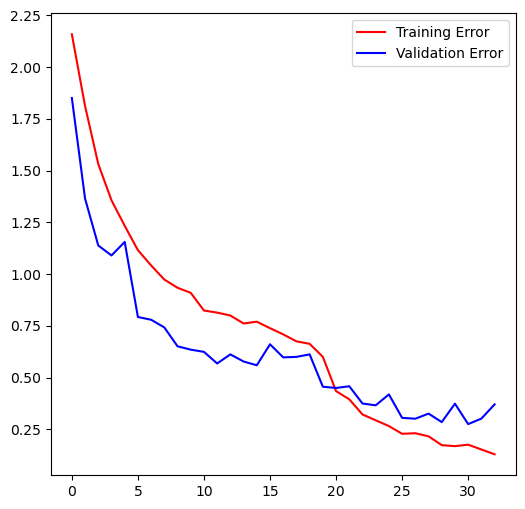

In [132]:
plt.figure(figsize=(6,6))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

Accuracy Graph

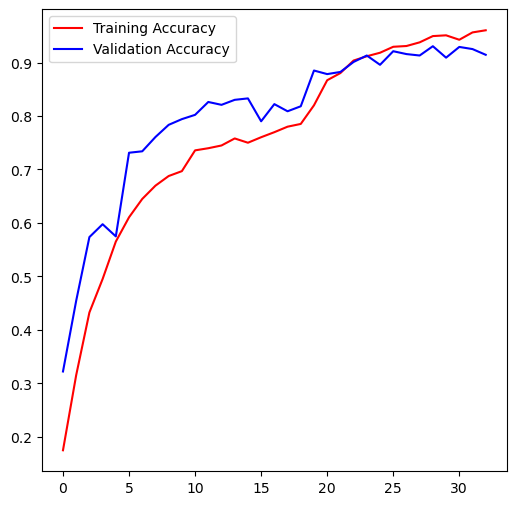

In [135]:
plt.figure(figsize=(6,6))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

Evaluating the model on the Test Set

In [140]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print("Loss on test set: {}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy*100))

Loss on test set: 0.2734771966934204
Accuracy on test set: 92.6862%


Plotting the Confusion Matrix

Loss on test set: 0.2537
Accuracy on test set: 92.6862%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━

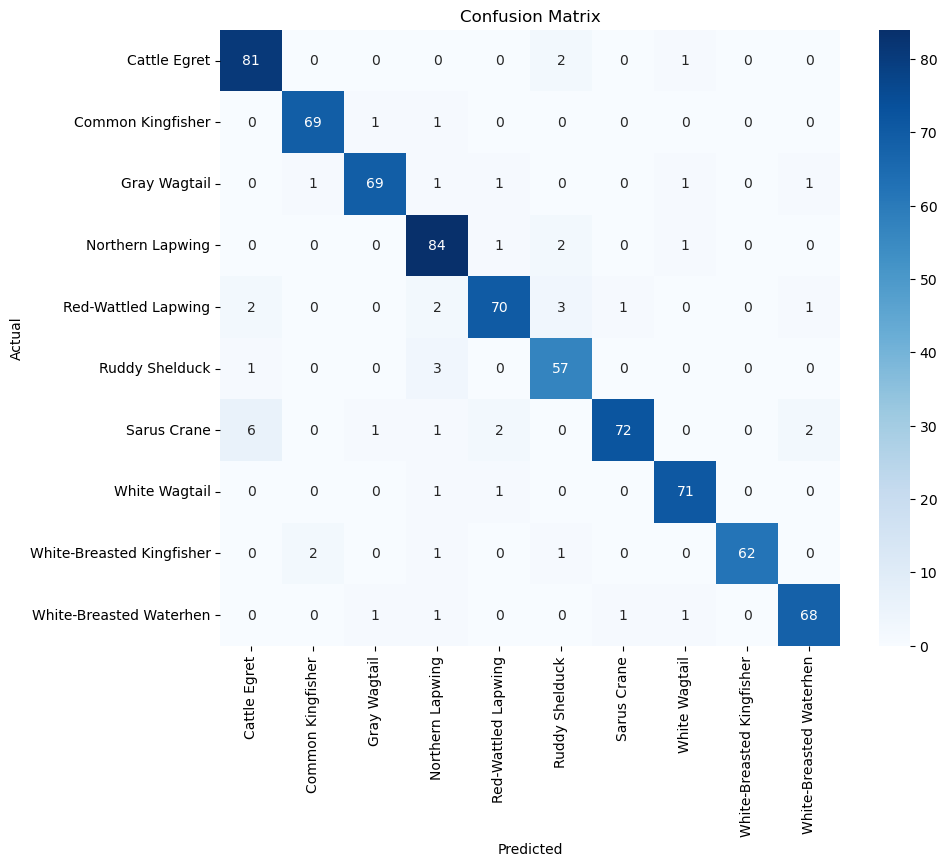

In [146]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print("Loss on test set: {:.4f}".format(test_loss))
print("Accuracy on test set: {:.4f}%".format(test_accuracy * 100))

# Generate predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_pred.extend(predicted_labels.numpy())

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Saving the final model

In [148]:
model.save('model/model.h5')

Making test predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load and preprocess the image
image = tf.keras.utils.load_img('Test_Image/test3.jpg')
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = tf.image.resize(input_arr, (224, 224))

# Make predictions
predictions = model.predict(input_arr, verbose=0)
score = tf.nn.softmax(predictions[0])
predicted_class = class_names[np.argmax(predictions)]
confidence = 100 * np.max(score)

# Display the image with prediction
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class} \nProbability: {confidence:.2f}%')
plt.show()